In [81]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn


## add your packages ##


# 2D visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap

# clustering
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

# graph interaction
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive

## end of ou packages ##

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("./data")
plt.style.use("../matplotlib_style.txt")

np.random.seed(42)

/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packag

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


# 0. Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [4]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [5]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [6]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

In [8]:
print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [9]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [10]:
cluster_colors.shape

(1329,)

In [11]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [12]:
rna_type.shape

(1329,)

In [13]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [14]:
clusterCols = np.array(list(dict_rna_type_colors.values()))
len(dict_rna_type_colors)

88

### Electrophysiological features

In [15]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [16]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [17]:
np.sum(np.isnan(ephysData_filtered))

0

# 1. Data Inspection


First, to get a feeling for the data at hand, we try to visualize it and compute some statistics...

In [18]:
exonCounts.shape

(1329, 42466)

In [19]:
# test for nans
assert np.sum(np.isnan(exonCounts)) == 0

# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

In [20]:
exonCounts.shape

(1329, 42197)

## 1.1. Compute Statistics

In [21]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts, axis=0)
frac_zeros = np.mean(exonCounts == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

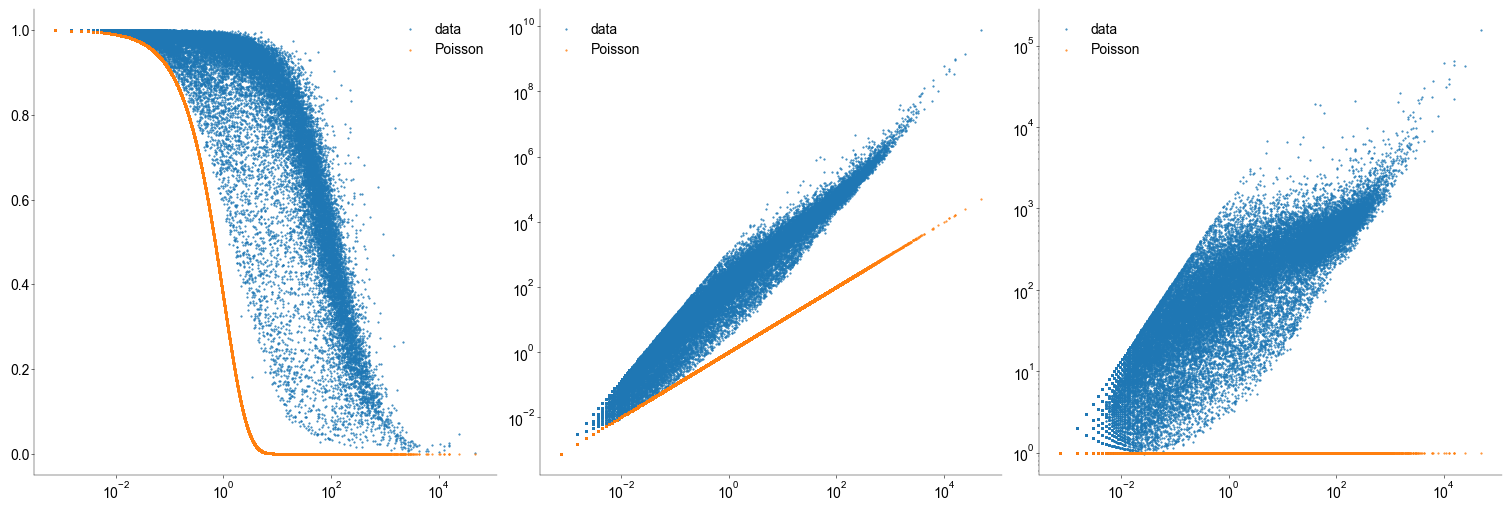

In [22]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

## 1.2. Histogram of Sequencing Depths

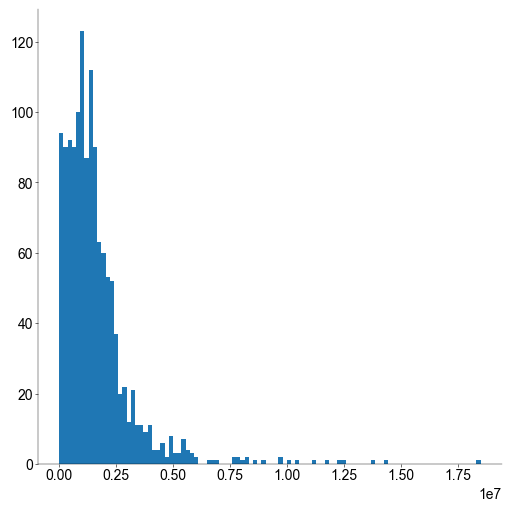

In [23]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts, axis=1), bins=100)

plt.show()

# TODO: why does this look so much different from that in the exercise sheet (esp. x-axis)

# 2. Data Normalization and Transformation

In the following section we .... bliblablub




## 2.1. Like in the Exercise Sheet

In [24]:
# first we normalize equivalently to what we did in the exercise sheet
norm_counts = (
    exonCounts
    / np.sum(exonCounts, axis=1)[:, None]
    * np.median(np.sum(exonCounts, axis=1))
)
mean_norm_counts = np.mean(norm_counts, axis=0)
var_norm_counts = np.var(norm_counts, axis=0)
fano_norm_counts = var_norm_counts / mean_norm_counts

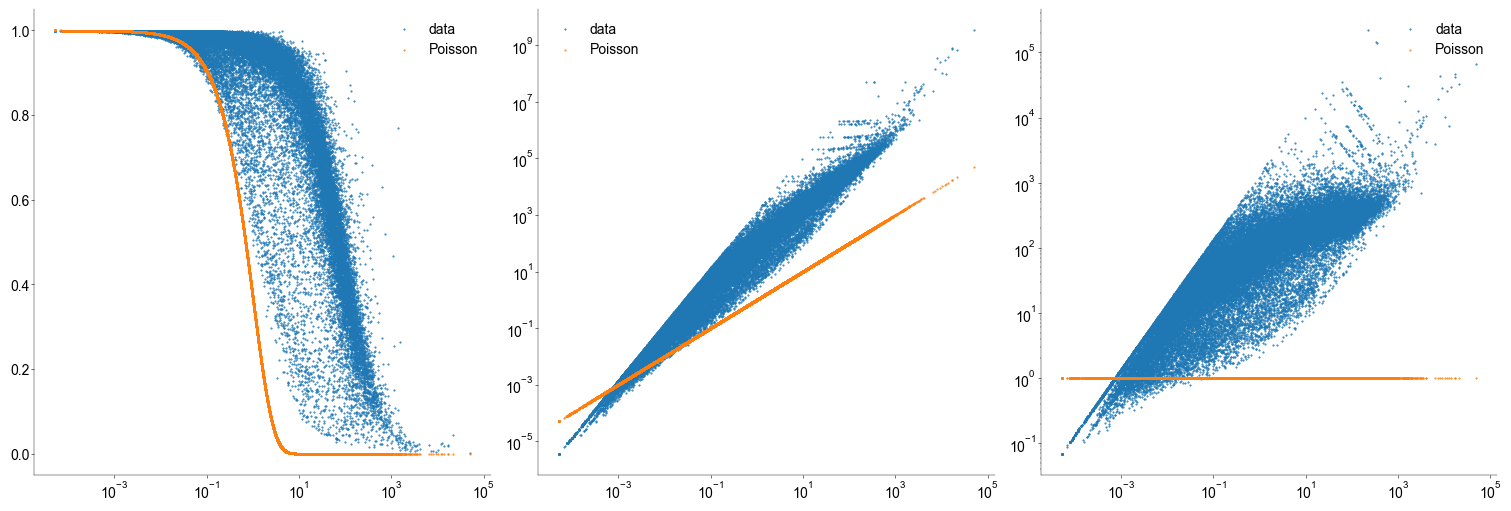

In [25]:
# produce similar plot as above

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(mean_norm_counts, frac_zeros, s=1, label="data")
axs[0].scatter(
    mean_norm_counts, np.exp(-mean_norm_counts), s=1, label="Poisson"
)

axs[1].scatter(mean_norm_counts, var_norm_counts, s=1, label="data")
axs[1].scatter(mean_norm_counts, mean_norm_counts, s=1, label="Poisson")

axs[2].scatter(mean_norm_counts, fano_norm_counts, s=1, label="data")
axs[2].scatter(
    mean_norm_counts, np.ones_like(mean_norm_counts), s=1, label="Poisson"
)

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

In [26]:
raw_counts_gr_three = norm_counts[:, fano_norm_counts > 3]

raw_counts_log = np.log(raw_counts_gr_three + 1)  # + 1 to avoid log(0)
raw_counts_sqrt = np.sqrt(raw_counts_gr_three)

## 2.2. Counts per million

In [27]:
from bioinfokit.analys import norm, get_data

In [28]:
# convert exonCounts to dataframe
df = pd.DataFrame(exonCounts.T, columns=cells, index=genes)

In [29]:
nm = norm()
nm.cpm(df)

cpm_df = nm.cpm_norm

In [30]:
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## 2.3. RPKM


In [31]:
# add column with lengths to df
df["length"] = exonLengths
df.head()

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3,length
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3583
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2128
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,271,0,0,0,0,138,0,78,89,998
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,1,0,0,0,1803
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,619


In [32]:
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

In [33]:
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)  # + 1 to avoid log(0)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

we now compile a dict of all normalized counts (with and without transformations) and then Visualize them with different 2D Visualiation methods

In [70]:
# TODO maybe change counts to more appropriate name e.g. raw_counts? - will be used in plotting title
count_dict = {
    "raw": {
        "counts": raw_counts_gr_three,
        "log": raw_counts_log,
        "sqrt": raw_counts_sqrt,
    },
    "cpm": {
        "counts": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "counts": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}

(1329, 42197)

### 3.1 PCA


first, as a baseline we will perform PCA and visualize the first two components

In [35]:
# perform PCA
pca = PCA(n_components=50)
pca_results = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)

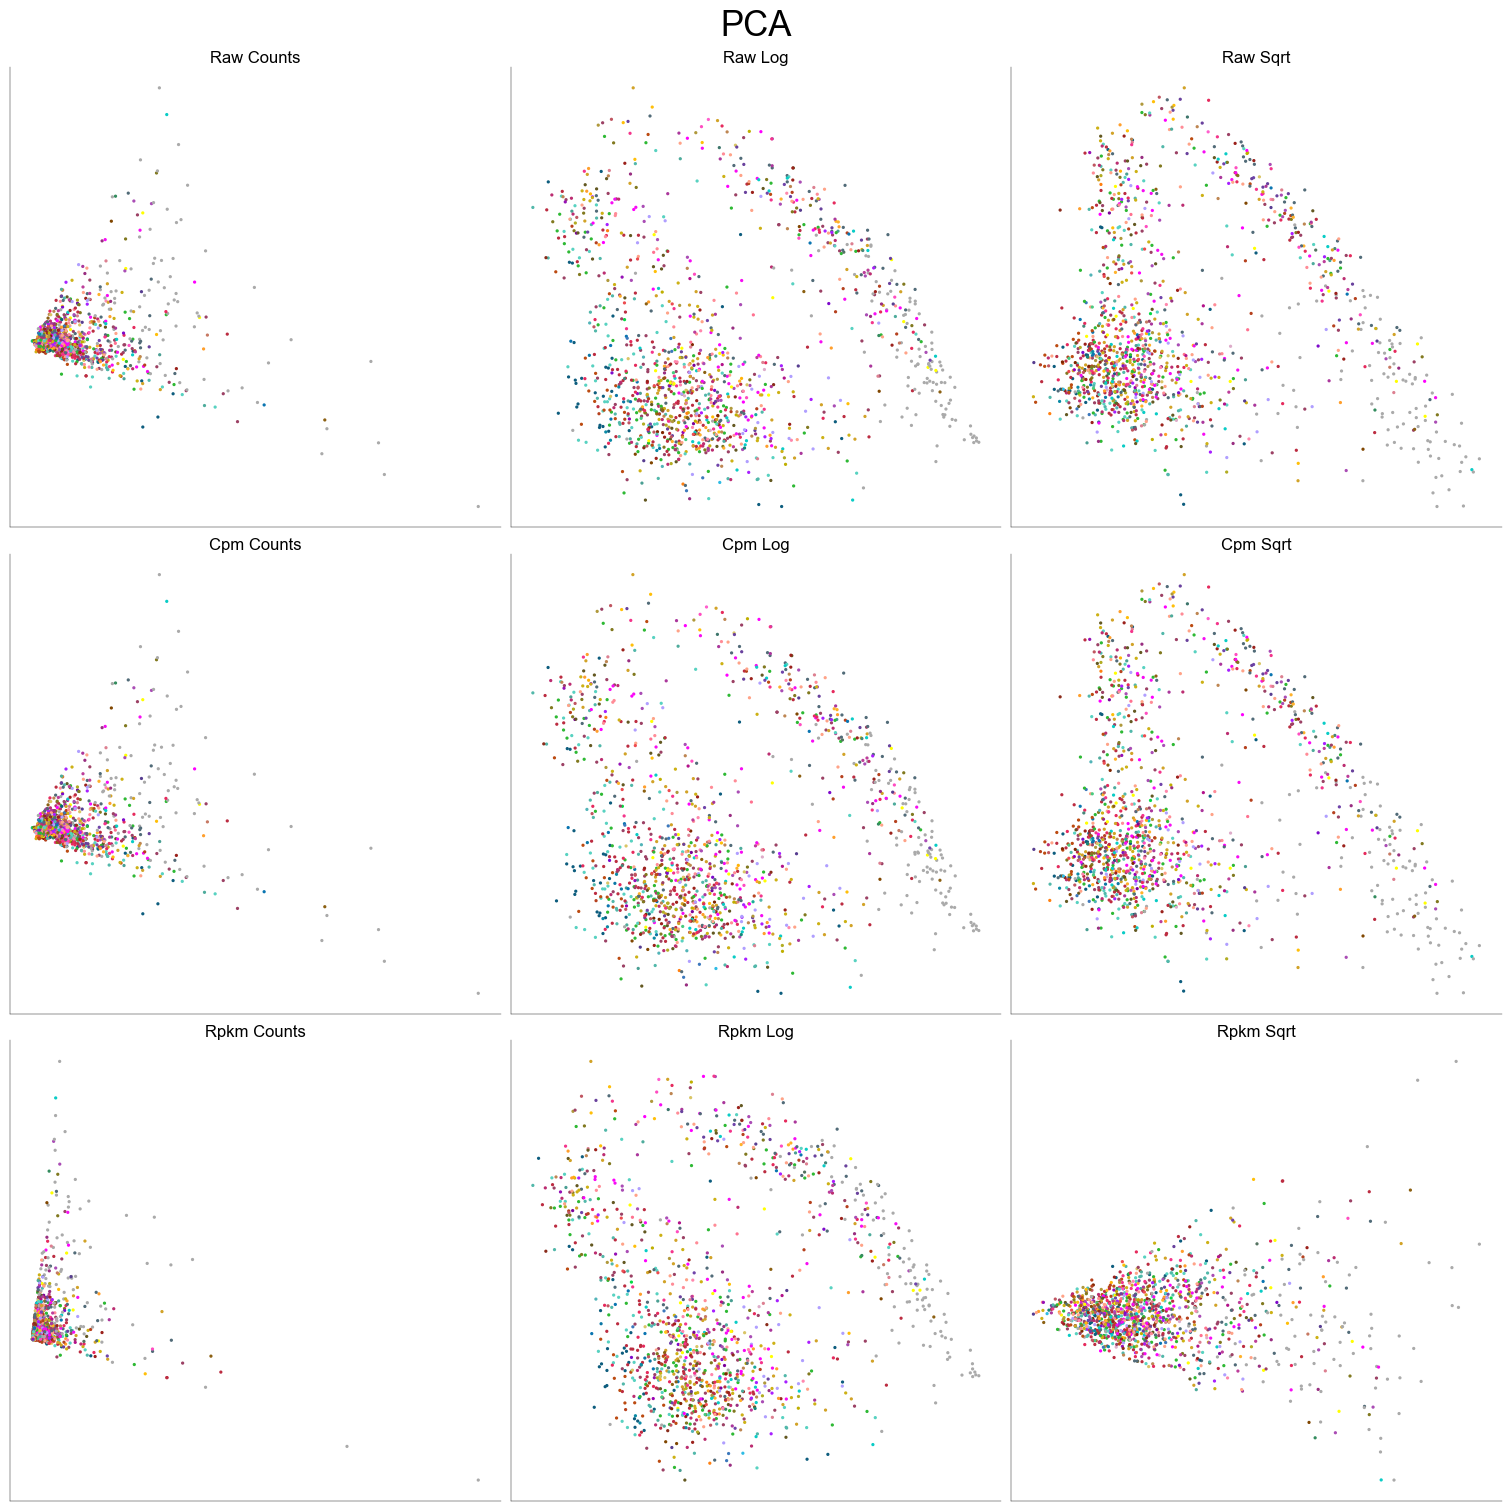

In [36]:
# plot PCA
fig, axs = plt.subplots(
    len(pca_results.keys()),
    len(list(pca_results.values())[0].keys()),
    figsize=(15, 15),
)
fig.suptitle("PCA", fontsize=25)
for i, (norm_key, sub_dict) in enumerate(pca_results.items()):
    for j, (trans_key, components) in enumerate(sub_dict.items()):
        axs[i, j].scatter(
            components[:, 0],
            components[:, 1],
            s=7,
            c=cluster_colors,
        )
        axs[i, j].set_title(f"{norm_key} {trans_key}".title())
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.show()

#### TODO analysis

### 3.2 t-SNE

In [74]:
def plot_tsne(perplexity, exaggeration):
    # display loading bar
    loading_bar = widgets.IntProgress(
        value=0,
        min=0,
        max=len(pca_results.keys())
        * len(list(pca_results.values())[0].keys()),
        description="Loading data",
        bar_style="",
        style={"bar_color": "green"},
        orientation="horizontal",
    )
    display(loading_bar)

    # perform t-SNE of PCA results
    exaggeration = exaggeration if exaggeration else None
    tsne = TSNE(perplexity=perplexity, exaggeration=exaggeration)
    tsne_results = dict()
    for norm_key, sub_dict in pca_results.items():
        tsne_results[norm_key] = dict()
        for trans_key, counts in sub_dict.items():
            tsne_results[norm_key][trans_key] = tsne.fit(counts)
            loading_bar.value += 1

    # plot t-SNE
    fig, axs = plt.subplots(
        len(tsne_results.keys()),
        len(list(tsne_results.values())[0].keys()),
        figsize=(15, 15),
    )
    fig.suptitle("t-SNE", fontsize=25)
    for i, (norm_key, sub_dict) in enumerate(tsne_results.items()):
        for j, (trans_key, result) in enumerate(sub_dict.items()):
            axs[i, j].scatter(
                result[:, 0],
                result[:, 1],
                s=7,
                c=cluster_colors,
            )
            axs[i, j].set_title(f"{norm_key} {trans_key}".title())
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])


perplexity_box = widgets.BoundedIntText(value=20, min=1, max=1000, step=10)
exaggeration_box = widgets.BoundedIntText(value=12, min=0, max=1000)
interact(plot_tsne, perplexity=perplexity_box, exaggeration=exaggeration_box)

interactive(children=(BoundedIntText(value=20, description='perplexity', max=1000, min=1, step=10), BoundedInt…

<function __main__.plot_tsne(perplexity, exaggeration)>

Tested Combinations:  
p; e  
1; 1  
400; 1  
20; 12  
400; 12  
400; 0  
200; 0  
200; 1  
200; 4  
100; 4
100; 1

**NOTES** 
- the higher perplexity, the longer loading time
- if plot shows multiple times, reload window

IntProgress(value=0, description='Loading data', max=9, style=ProgressStyle(bar_color='green'))

Plotting...


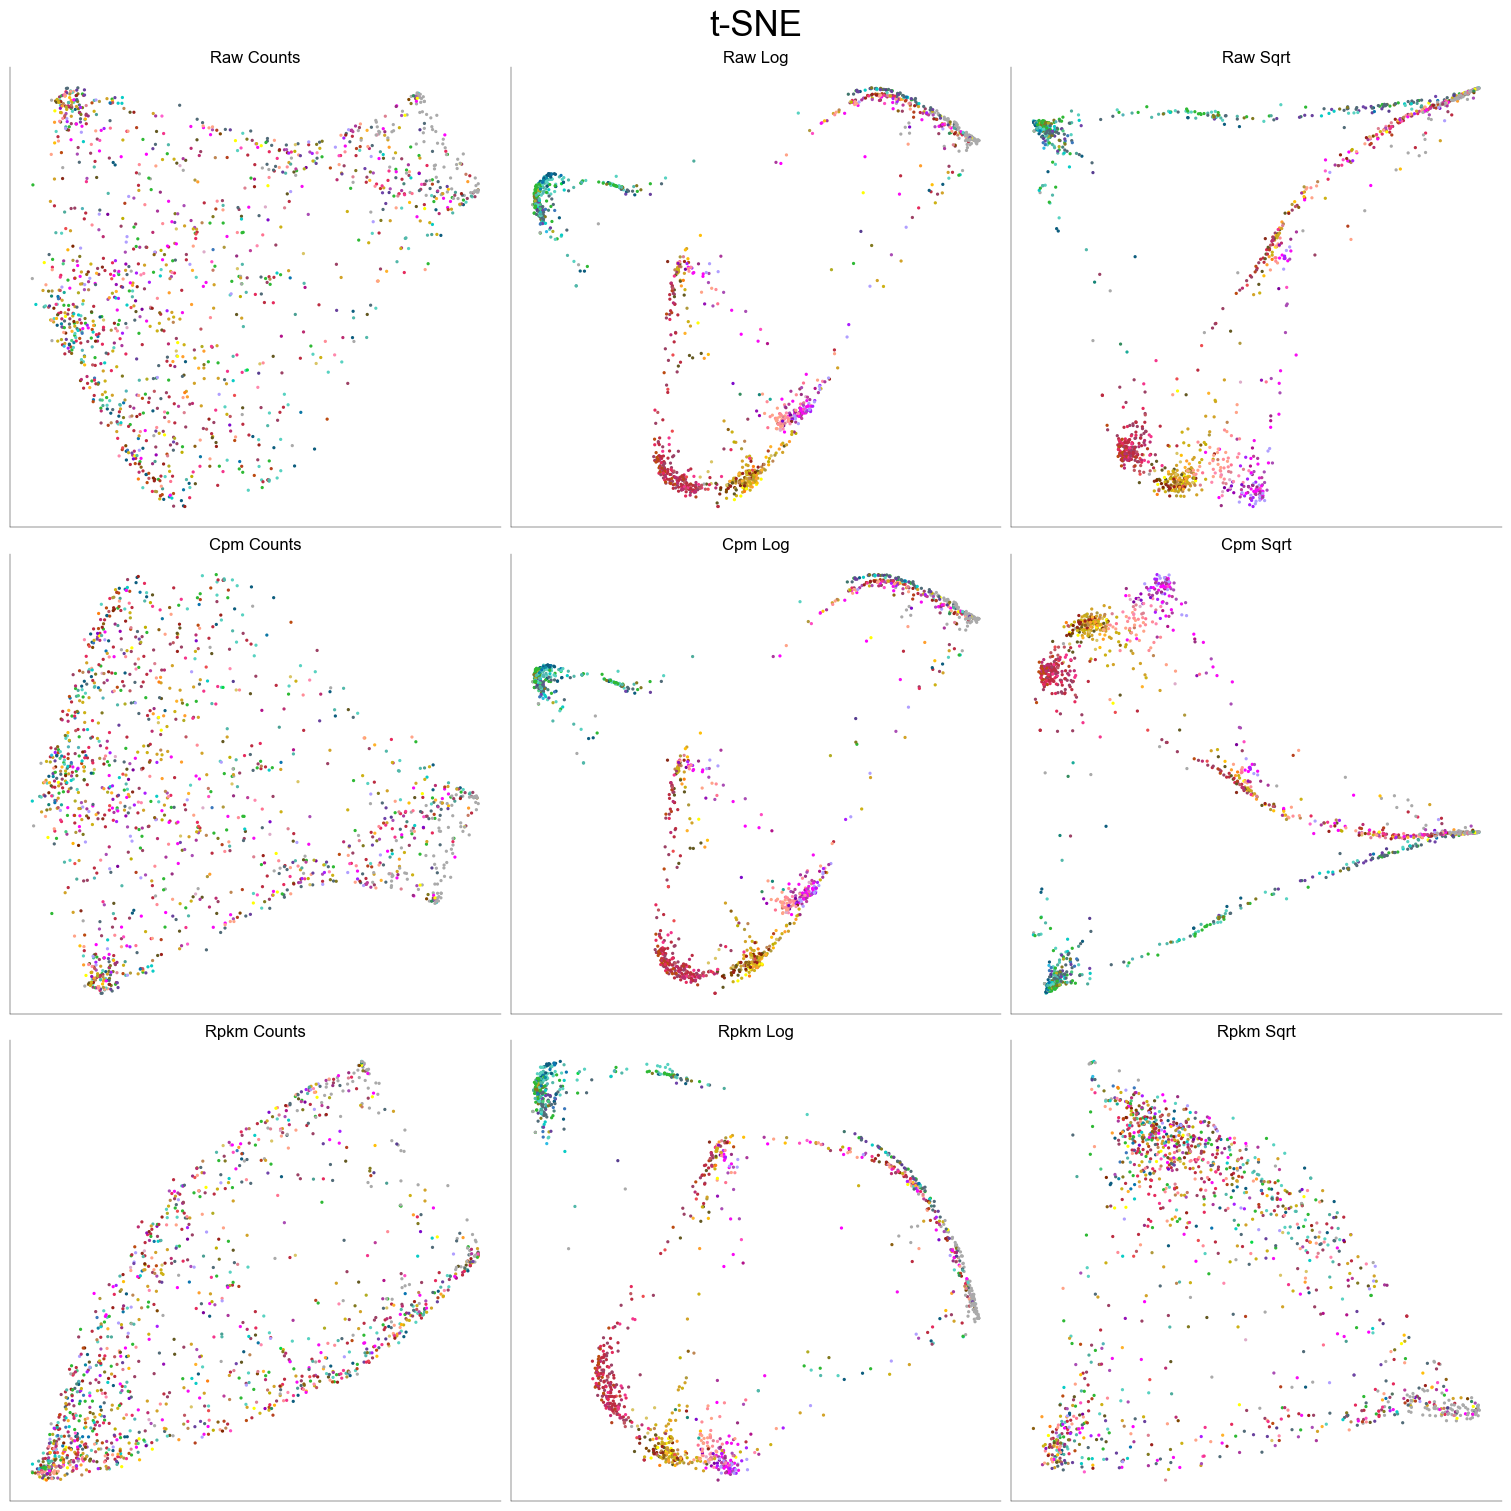

In [76]:
plot_tsne(100, 4)  # TODO insert chosen values

#### TODO analysis

### 3.3 UMAP

In [87]:
def plot_umap():
    # perform t-SNE of PCA results
    umap_func = umap.UMAP()
    umap_results = dict()
    for norm_key, sub_dict in pca_results.items():
        umap_results[norm_key] = dict()
        for trans_key, counts in sub_dict.items():
            umap_results[norm_key][trans_key] = umap_func.fit_transform(counts)

    # plot t-SNE
    fig, axs = plt.subplots(
        len(umap_results.keys()),
        len(list(umap_results.values())[0].keys()),
        figsize=(15, 15),
    )
    fig.suptitle("UMAP", fontsize=25)
    for i, (norm_key, sub_dict) in enumerate(umap_results.items()):
        for j, (trans_key, result) in enumerate(sub_dict.items()):
            axs[i, j].scatter(
                result[:, 0],
                result[:, 1],
                s=7,
                c=cluster_colors,
            )
            axs[i, j].set_title(f"{norm_key} {trans_key}".title())
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

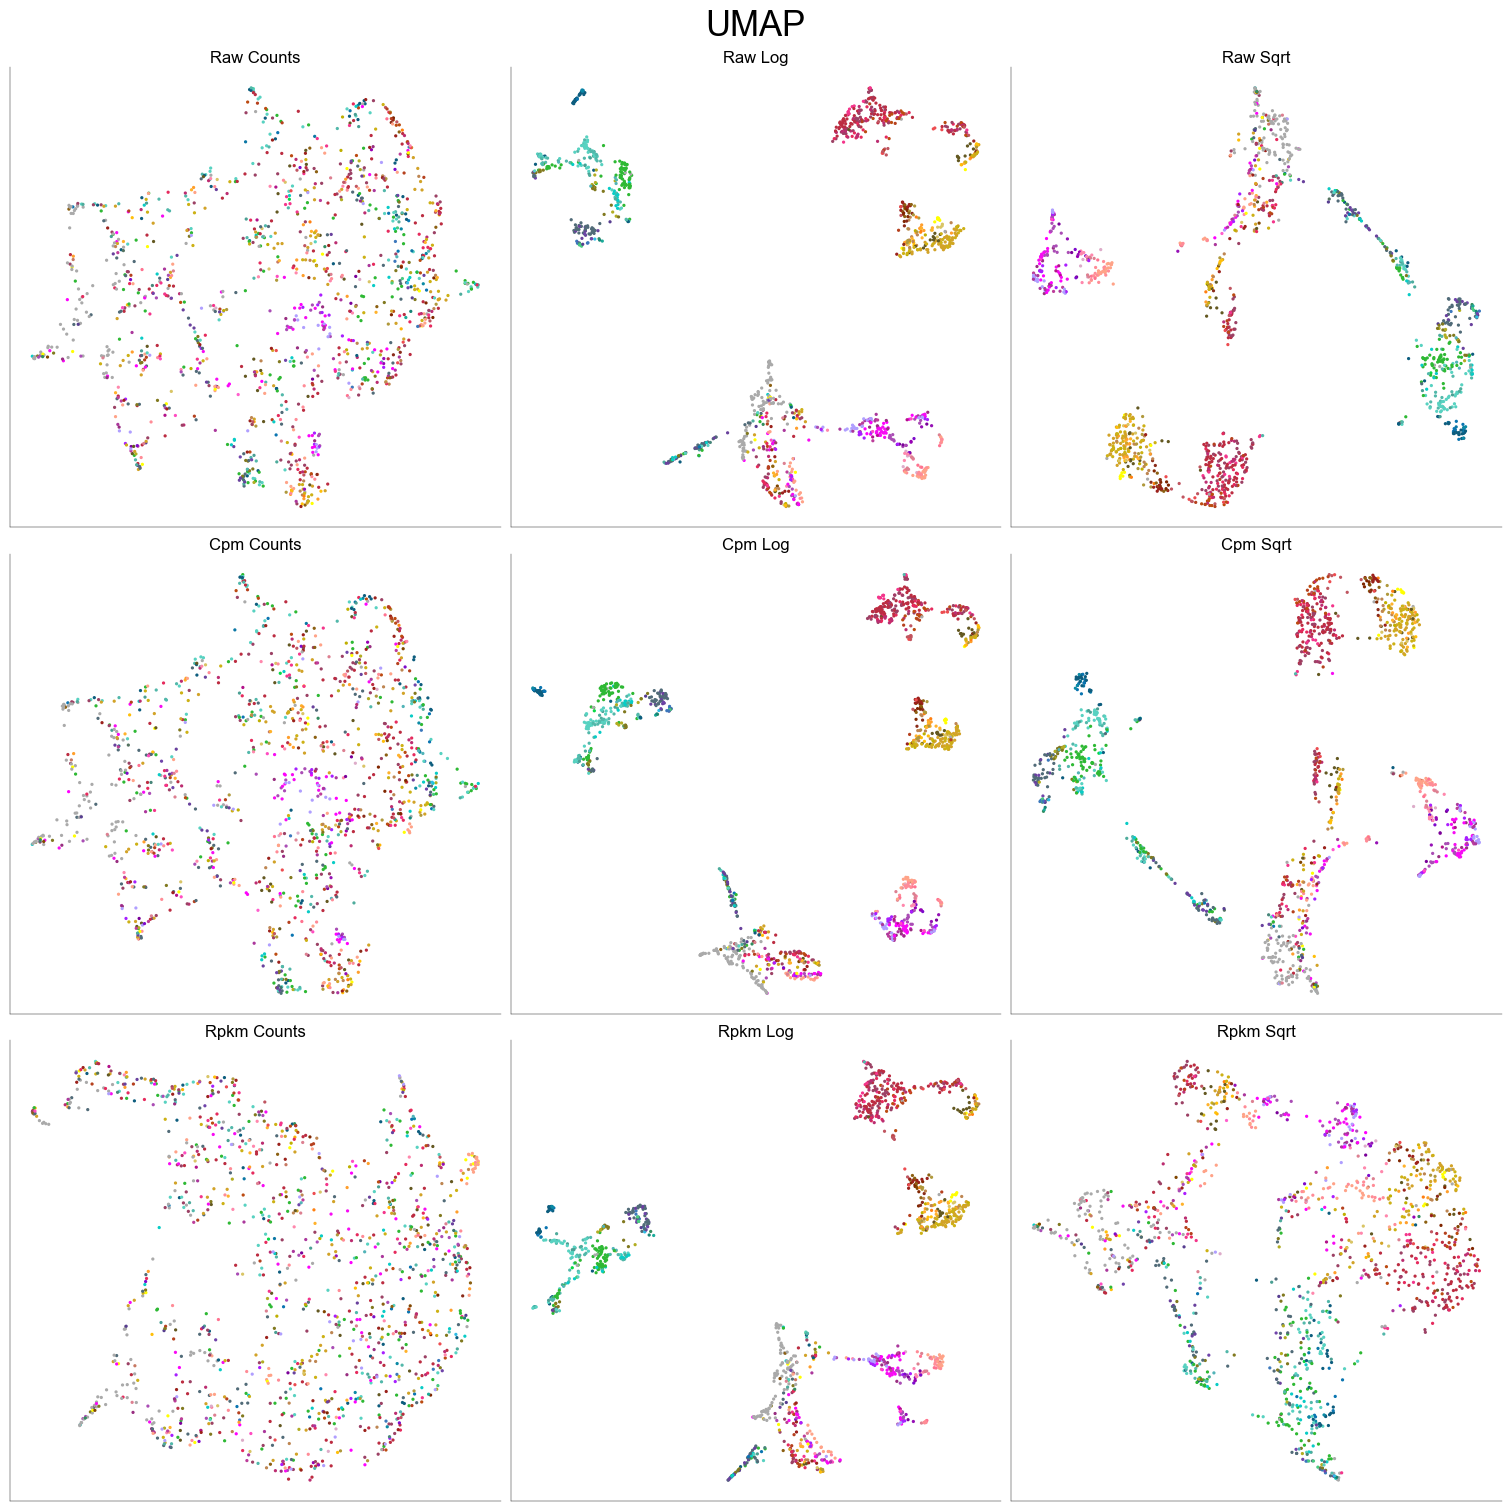

In [88]:
plot_umap()

# 4. Clustering

## 4.1 Leiden Clustering

### 4.1.1 Raw counts

In [38]:
# tsne_gr_three = tsne.fit(fit_gr_three)
# tsne_log = tsne.fit(fit_log)
# tsne_sqrt = tsne.fit(fit_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(raw_fit_2, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_gr_three[:, 0],
    tsne_gr_three[:, 1],
    s=2,
    c=clusterCols[partition.membership],
)
ax.set_title("Raw")
plt.show()
np.unique(partition.membership, return_counts=True)

NameError: name 'raw_fit_2' is not defined

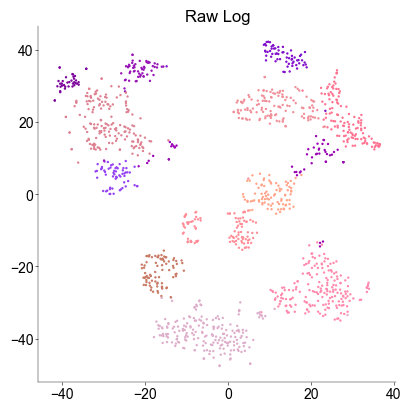

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([197, 185, 166, 125, 124,  98,  88,  80,  63,  59,  56,  51,  37]))

In [ ]:
# tsne_gr_three = tsne.fit(fit_gr_three)
# tsne_log = tsne.fit(fit_log)
# tsne_sqrt = tsne.fit(fit_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(raw_fit_log_2, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_log[:, 0], tsne_log[:, 1], s=2, c=clusterCols[partition.membership]
)
ax.set_title("Raw Log")
plt.show()
np.unique(partition.membership, return_counts=True)

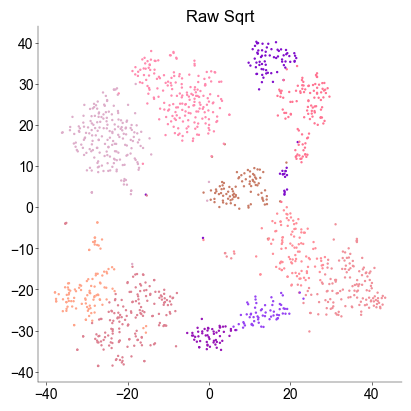

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([196, 195, 176, 145, 113, 111, 105,  88,  84,  62,  54]))

In [ ]:
# tsne_gr_three = tsne.fit(fit_gr_three)
# tsne_log = tsne.fit(fit_log)
# tsne_sqrt = tsne.fit(fit_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(raw_fit_sqrt_2, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_sqrt[:, 0], tsne_sqrt[:, 1], s=2, c=clusterCols[partition.membership]
)
ax.set_title("Raw Sqrt")
plt.show()
np.unique(partition.membership, return_counts=True)

### 4.1.2 CPM

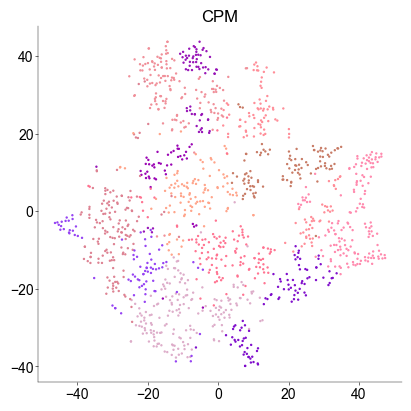

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([177, 152, 145, 134, 118, 111, 106, 101,  94,  81,  67,  43]))

In [ ]:
# tsne_cpm = tsne.fit(fit_cpm)
# tsne_cpm_log = tsne.fit(fit_cpm_log)
# tsne_cpm_sqrt = tsne.fit(fit_cpm_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(fit_cpm, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_cpm[:, 0], tsne_cpm[:, 1], s=2, c=clusterCols[partition.membership]
)
ax.set_title("CPM")
plt.show()
np.unique(partition.membership, return_counts=True)

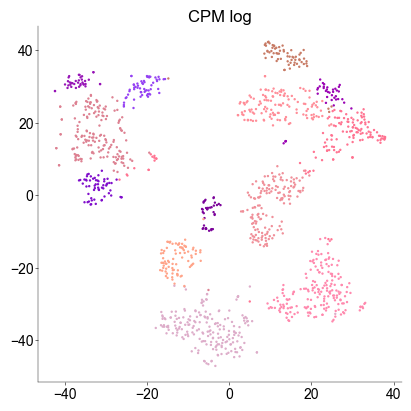

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([197, 186, 165, 151, 132, 127,  81,  65,  59,  57,  37,  37,  35]))

In [ ]:
# tsne_cpm = tsne.fit(fit_cpm)
# tsne_cpm_log = tsne.fit(fit_cpm_log)
# tsne_cpm_sqrt = tsne.fit(fit_cpm_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(fit_cpm_log, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_cpm_log[:, 0],
    tsne_cpm_log[:, 1],
    s=2,
    c=clusterCols[partition.membership],
)
ax.set_title("CPM log")
plt.show()
np.unique(partition.membership, return_counts=True)

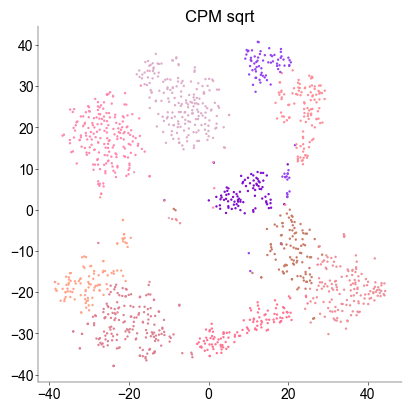

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([197, 195, 176, 151, 116, 114, 106, 103,  87,  84]))

In [ ]:
# tsne_cpm = tsne.fit(fit_cpm)
# tsne_cpm_log = tsne.fit(fit_cpm_log)
# tsne_cpm_sqrt = tsne.fit(fit_cpm_sqrt)

# Raw
# Construct kNN graph with k=15
A = kneighbors_graph(fit_cpm_sqrt, 15)
# Transform it into an igraph object
sources, targets = A.nonzero()

g = ig.Graph(directed=False)
g.add_vertices(A.shape[0])
g.add_edges(list(zip(sources, targets)))

partition = la.find_partition(g, la.RBConfigurationVertexPartition)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    tsne_cpm_sqrt[:, 0],
    tsne_cpm_sqrt[:, 1],
    s=2,
    c=clusterCols[partition.membership],
)
ax.set_title("CPM sqrt")
plt.show()
np.unique(partition.membership, return_counts=True)

# 5. Correlation in between Electrophysiological Features and Genes/PCs

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    